# Lab 11-3: Sequence Model of GRU
## Exercise: Sentiment Analysis of Movie Reviews
This exercise is based on the notebook in TensorFlow Tutorials.<br>
https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Loading IMDB standard dataset using the Keras dataset class.

num_words = 10000 signifies that only 10000 unique words will be taken for our dataset.

x_train, x_test: List of movie reviews text data. having an uneven length.

y_train, y_test: Lists of integer target labels (1 or 0).

In [2]:
#from keras.datasets import imdb
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
                                         split=['train', 'test'],  # + 'unsupervised'
                                         shuffle_files=True, 
                                         as_supervised=True, 
                                         with_info=True)

print(ds_info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePUECXV/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePUECXV/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePUECXV/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})


We are defining max_len = 200. If a sentence is having a length greater than 200 it will be trimmed off otherwise it will be padded by 0.

In [12]:
X_train = []
y_train = []

X_test_str = []
y_test = []

for sentense, label in ds_train:
    X_train.append(sentense.numpy().decode('utf8'))
    y_train.append(label.numpy())

for sentense, label in ds_test:
    X_test_str.append(sentense.numpy().decode('utf8'))  # X_test_str is used at the test stage
    y_test.append(label.numpy())

y_train = np.array(y_train)
y_test = np.array(y_test)

In [13]:
print(X_train[0])
print('The review is', 'Positive' if y_train[0]==1 else 'Negative')

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
The review is Negative


## Tokenizer and Integer encoding

In [14]:
# hyperparameter for word embeddings
vocab_size = 10000
embedding_size = 128
max_length = 300

### START CODE HERE ###

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test_str)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', truncating='post', maxlen=max_length)
X_test  = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', truncating='post', maxlen=max_length)

### END CODE HERE ###

input_length = maxlen Since we have already made all sentences in our dataset have an equal length of 200 using pad_sequence.
The Embedding layer takes n_unique_words as the size of the vocabulary in our dataset which we already declared as 10000.
After the Embedding layer, we are adding Bi-directional LSTM units.
Using sigmoid activation and then compiling the model

In [26]:
hidden_states = 64
dropout_rate = 0.5

model = tf.keras.Sequential()
### START CODE HERE ###

model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size))  # embedding layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=hidden_states)))  # bidirectional GRU
model.add(tf.keras.layers.Dropout(rate=dropout_rate))  # dropout
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # output layer

### END CODE HERE ###

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________


In [27]:
n_batch = 64

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = tf.keras.callbacks.ModelCheckpoint('GRU_imdb.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

results = model.fit(X_train, y_train,
            batch_size=n_batch,
            epochs=10,
            callbacks=[es, mc],
            validation_split=0.2)

print(results.history['loss'])
print(results.history['accuracy'])

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.6747
Epoch 1: val_accuracy improved from -inf to 0.71360, saving model to GRU_imdb.h5
313/313 [==============================] - 12s 30ms/step - loss: 0.5949 - accuracy: 0.6747 - val_loss: 0.5514 - val_accuracy: 0.7136
Epoch 2/10
312/313 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8460
Epoch 2: val_accuracy improved from 0.71360 to 0.85180, saving model to GRU_imdb.h5
313/313 [==============================] - 9s 28ms/step - loss: 0.3656 - accuracy: 0.8460 - val_loss: 0.3610 - val_accuracy: 0.8518
Epoch 3/10
312/313 [============================>.] - ETA: 0s - loss: 0.2470 - accuracy: 0.9069
Epoch 3: val_accuracy improved from 0.85180 to 0.85620, saving model to GRU_imdb.h5
313/313 [==============================] - 9s 28ms/step - loss: 0.2469 - accuracy: 0.9069 - val_loss: 0.3487 - val_accuracy: 0.8562
Epoch 4/10
312/313 [============================>.] - ETA: 0s - lo

Plot Convergence Graph

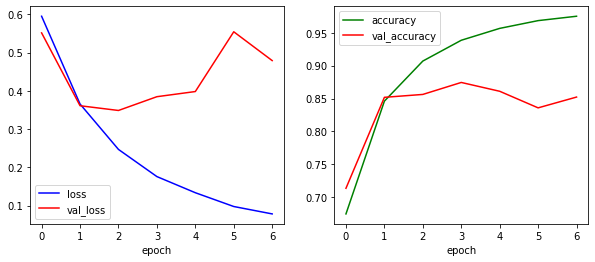

In [28]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['accuracy'], 'g-', label='accuracy')
plt.plot(results.history['val_accuracy'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Evaluate the model

In [29]:
# model = tf.keras.models.load_model('GRU_imdb.h5')
model.evaluate(X_test, y_test)

782/782 [==============================] - 9s 11ms/step - loss: 0.5562 - accuracy: 0.8371


[0.5562431216239929, 0.8370800018310547]

### Test Model with a random review

In [30]:
idx = np.random.randint(X_test.shape[0])

X_input = X_test[idx].reshape(1,-1)
score = float(model.predict(X_input))

decision = 1 if score>0.5 else 0
rate = score if decision==1 else (1-score)

print(X_test_str[idx])

print('The review is', 'Positive' if decision==1 else 'Negative', 'in {:.2f}% '.format(rate*100))

#print(X_input.shape)

I saw this movie because it had a giant person and was labeled as a monster movie. I do not understand why it is called a monster movie. The movie is a drama. I was expecting a lot of destruction, but what did I get? Most of the movie was relationship problems and people thinking that a woman was a loony because she saw a spaceship crash with a giant inside for an unexplained reason. The action started a few minutes toward the end. Since the woman was killed, isn't that murder? Couldn't they have done anything else besides murder her? If you watch this because you expect it to have action because it is labeled as a monster movie, don't watch it. It is not a monster movie. It is a drama.
The review is Negative in 98.86% 
